<a href="https://colab.research.google.com/github/Anujpratap9997/DeepLearning/blob/main/Keras_functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [28]:
!kaggle datasets download -d jangedoo/utkface-new

utkface-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [29]:
import zipfile
zip = zipfile.ZipFile("/content/utkface-new.zip",'r')
zip.extractall("/content")
zip.close()

In [30]:
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

In [31]:
folder_path = '/content/utkface_aligned_cropped/UTKFace'

In [32]:
age=[]
gender=[]
img_path=[]

for file in os.listdir(folder_path):
  age.append(int(file.split('_')[0]))
  gender.append(int(file.split('_')[1]))
  img_path.append(file)

In [33]:
len(age)

23708

In [34]:
df = pd.DataFrame({'age':age,'gender':gender,'img':img_path})

In [35]:
df.shape

(23708, 3)

In [36]:
df.head()

,age,gender,img
0,29,0,29_0_0_20170104202211753.jpg.chip.jpg
1,39,0,39_0_0_20170117121745777.jpg.chip.jpg
2,2,0,2_0_2_20161219212013262.jpg.chip.jpg
3,55,0,55_0_3_20170119181425916.jpg.chip.jpg
4,47,0,47_0_3_20170119183143206.jpg.chip.jpg


In [37]:
train_df=df.sample(frac=1,random_state=0).iloc[:20000]
test_df=df.sample(frac=1,random_state=0).iloc[20000:]

In [38]:
train_df.shape

(20000, 3)

In [39]:
test_df.shape

(3708, 3)

In [40]:
train_datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen=ImageDataGenerator(rescale=1./255)

In [41]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory=folder_path,
                                                    x_col='img',
                                                    y_col=['age','gender'],
                                                    target_size=(200,200),
                                                    class_mode='multi_output'
                                                    )
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                  directory=folder_path,
                                                  x_col='img',
                                                  y_col=['age','gender'],
                                                  target_size=(200,200),
                                                  class_mode='multi_output'
                                                  )

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [42]:
from keras.applications.resnet50 import ResNet50
from keras.layers import *
from keras.models import Model

In [43]:
resnet=ResNet50(include_top=False, input_shape=(200,200,3))

In [44]:
resnet=ResNet50(include_top=False, input_shape=(200,200,3))

resnet.trainable=False

output =resnet.layers[-1].output

flatten=Flatten()(output)

dense1=Dense(512,activation='relu')(flatten)
dense2=Dense(512,activation='relu')(flatten)

dense3= Dense(512,activation='relu')(dense1)
dense4= Dense(512,activation='relu')(dense2)

output1=Dense(1,activation='linear',name='age')(dense3)
output2=Dense(1,activation='sigmoid',name='gender')(dense4)

In [45]:
model=Model(inputs=resnet.input,outputs=[output1,output2])

In [46]:
model.compile(optimizer='adam',loss={'age':'mae','gender':'binary_crossentropy'},metrics={'age':'mae','gender':'accuracy'},loss_weights={'age':1,'gender':99})

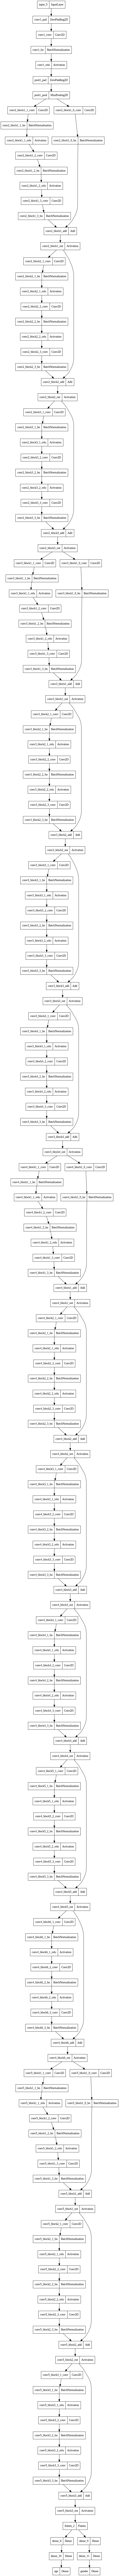

In [47]:
from keras.utils import plot_model
plot_model(model)

In [48]:
history=model.fit(train_generator,batch_size=32,epochs=10,validation_data=test_generator)

Epoch 1/10
625/625 [==============================] - 235s 367ms/step - loss: 105.3360 - age_loss: 15.5115 - gender_loss: 0.9073 - age_mae: 15.5115 - gender_accuracy: 0.5045 - val_loss: 84.7014 - val_age_loss: 16.2018 - val_gender_loss: 0.6919 - val_age_mae: 16.2018 - val_gender_accuracy: 0.5278
Epoch 2/10
625/625 [==============================] - 228s 365ms/step - loss: 83.7313 - age_loss: 14.8831 - gender_loss: 0.6954 - age_mae: 14.8831 - gender_accuracy: 0.5218 - val_loss: 83.6931 - val_age_loss: 15.1992 - val_gender_loss: 0.6919 - val_age_mae: 15.1992 - val_gender_accuracy: 0.5278
Epoch 3/10
625/625 [==============================] - 228s 364ms/step - loss: 83.3692 - age_loss: 14.8295 - gender_loss: 0.6923 - age_mae: 14.8295 - gender_accuracy: 0.5217 - val_loss: 83.5328 - val_age_loss: 15.0377 - val_gender_loss: 0.6919 - val_age_mae: 15.0377 - val_gender_accuracy: 0.5278
Epoch 4/10
625/625 [==============================] - 238s 381ms/step - loss: 83.7607 - age_loss: 14.8084 - gen